In [ ]:
# Bengaluru House Price Prediction (Linear Regression)
# IMPORTING LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# 1. DATA UNDERSTANDING & EXPLORATION

In [2]:
df = pd.read_csv('C:/Users/ESSICO/Desktop/TechCrush/Bengaluru_House_Data.csv')

In [3]:
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


In [ ]:
# Inspect dataset structure

In [4]:
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


(              area_type   availability                  location       size  \
 0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
 1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
 2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
 3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
 4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   
 
    society total_sqft  bath  balcony   price  
 0  Coomee        1056   2.0      1.0   39.07  
 1  Theanmp       2600   5.0      3.0  120.00  
 2      NaN       1440   2.0      3.0   62.00  
 3  Soiewre       1521   3.0      1.0   95.00  
 4      NaN       1200   2.0      1.0   51.00  ,
 None)

In [ ]:
# Missing values inspection

In [5]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [ ]:
# Target variable distribution

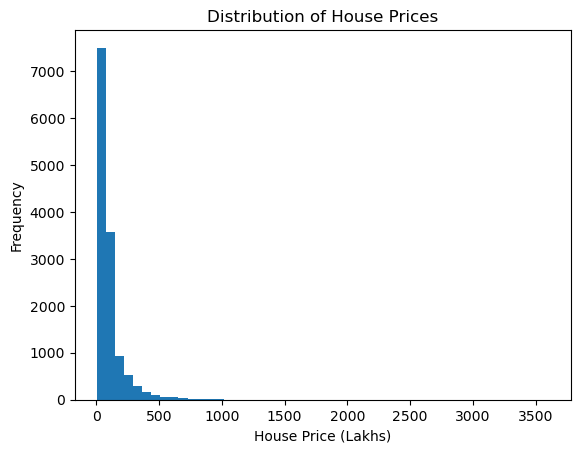

In [6]:
plt.figure()
plt.hist(df["price"], bins=50)
plt.xlabel("House Price (Lakhs)")
plt.ylabel("Frequency")
plt.title("Distribution of House Prices")
plt.show()

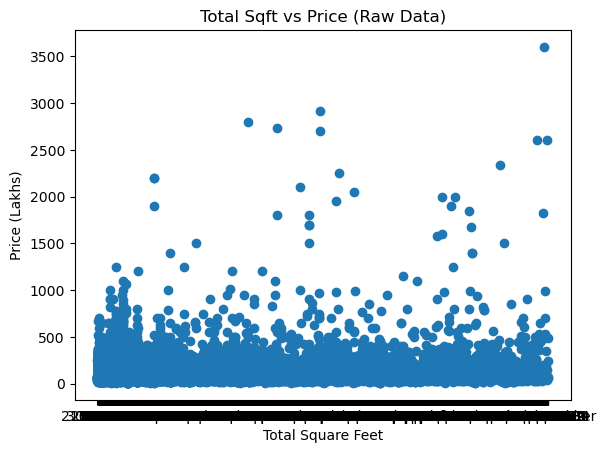

In [7]:
plt.figure()
plt.scatter(df["total_sqft"], df["price"])
plt.xlabel("Total Square Feet")
plt.ylabel("Price (Lakhs)")
plt.title("Total Sqft vs Price (Raw Data)")
plt.show()

In [ ]:
# 2. DATA CLEANING & PREPROCESSING

In [8]:
df = df.dropna(subset=["price"])

In [9]:
df["bath"] = df["bath"].fillna(df["bath"].median())
df["balcony"] = df["balcony"].fillna(df["balcony"].median())
df["size"] = df["size"].fillna(df["size"].mode()[0])

In [10]:
def convert_sqft(value):
    try:
        if "-" in value:
            a, b = value.split("-")
            return (float(a) + float(b)) / 2
        return float(value)
    except:
        return np.nan

In [11]:
df["total_sqft"] = df["total_sqft"].apply(convert_sqft)
df["total_sqft"] = df["total_sqft"].fillna(df["total_sqft"].median())

In [12]:
df["bhk"] = df["size"].apply(lambda x: int(x.split(" ")[0]))

In [13]:
location_counts = df["location"].value_counts()
rare_locations = location_counts[location_counts <= 10].index
df["location"] = df["location"].apply(lambda x: "Other" if x in rare_locations else x)

In [14]:
df["price_per_sqft"] = (df["price"] * 100000) / df["total_sqft"]
df = df[(df["price_per_sqft"] > 3000) & (df["price_per_sqft"] < 20000)]

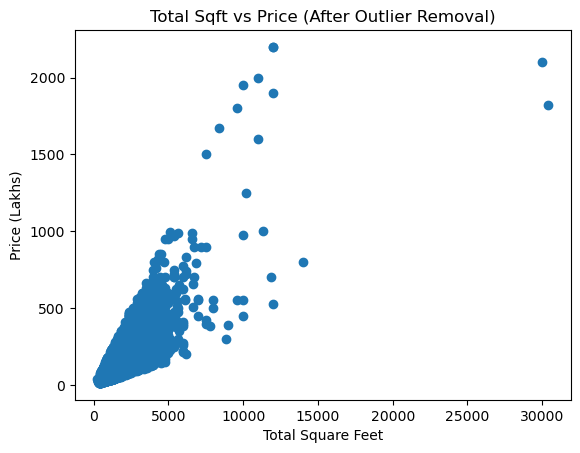

In [15]:
plt.figure()
plt.scatter(df["total_sqft"], df["price"])
plt.xlabel("Total Square Feet")
plt.ylabel("Price (Lakhs)")
plt.title("Total Sqft vs Price (After Outlier Removal)")
plt.show()

In [ ]:
# 3. MODEL BUILDING

In [16]:
X = df[["location", "total_sqft", "bath", "balcony", "bhk"]]
y = df["price"]

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["location"]),
        ("num", "passthrough", ["total_sqft", "bath", "balcony", "bhk"])
    ]
)

In [18]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['location']),
                                                 ('num', 'passthrough',
                                                  ['total_sqft', 'bath',
                                                   'balcony', 'bhk'])])),
                ('regressor', LinearRegression())])

In [ ]:
# 4. MODEL EVALUATION

In [21]:
y_pred = model.predict(X_test)

In [22]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [23]:
rmse

np.float64(56.69527990379751)

In [ ]:
# Result
# 56.69528367123228

# Interpretation

# On average, predictions differ from actual prices by ₹56.7 Lakhs

# Reasonable baseline performance for real-world housing data ###